In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

from sklearn.model_selection import GridSearchCV

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [2]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy


## Load analysis file

In [4]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')  

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.109101,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,4.795929,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,4.842301,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333


In [5]:
assert df_box.dropna().shape[0] == df_box.shape[0]

In [6]:
df_box.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_box.columns[df_box.columns.get_loc("totpop"):df_box.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full;

In [7]:
outcomes= ["dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]
df_box[outcomes].head()

,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,32.666667,6,1.200000
1,42.333333,3,3.000000
2,36.880000,25,1.923077
3,15.600000,5,1.666667
4,32.181818,44,2.933333


# (0) Prep data

In [8]:
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357528e+04,2.571084e+04,1.933244,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.617813,...,1.993614,45.607389,54.392611,8.104744,9.827415,2.696305,1.891626,40.335653,27.951859,2.381331
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.845988,...,1.846193,26.055808,26.055808,6.618311,8.148408,1.179745,0.752555,18.500212,48.572309,2.800509
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226120e+03,1925.107672,...,0.660968,23.841841,30.651477,3.421687,3.740358,2.090909,1.571429,32.290179,5.000000,1.200000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,1.555701,44.368239,55.631761,6.309751,8.125000,2.909091,2.000000,40.333333,13.000000,1.666667
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,2.786200,69.348523,76.158159,10.875723,13.930348,3.312500,2.250000,49.910985,31.000000,2.538462
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,12.851406,100.000000,100.000000,53.578192,55.087359,23.928571,13.500000,450.000000,1288.000000,80.500000


In [9]:
df_box.loc[df_box["avg_fire_ev_yr"]==0].shape[0]/df_box.shape[0]

0.0625920471281296

In [10]:
# assert no missingness
assert (df_box.isna().sum(axis = 0).sum() == 0)

In [11]:
df_box_clean= df_box.dropna(how = "any")
df_box_clean.shape

(10864, 80)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X = df_box_clean.loc[:, predictors_full]
y = df_box_clean.loc[X.index, outcomes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

# (1) Decision Trees and Random Forest Models
* All are negative, suggests the model isn't performing very well

In [67]:
from sklearn.metrics import mean_squared_error
for c in range(3):
    print("\nDecision tree for", outcomes[c])
    print()
    
    dt1 = DecisionTreeRegressor(max_depth=10, random_state = 99)
    dt1.fit(X_train, y_train.iloc[:, c])

    dt2 = DecisionTreeRegressor(max_depth=15, random_state = 99)
    dt2.fit(X_train, y_train.iloc[:, c])

    y_pred1= dt1.predict(X_test)
    y_pred2= dt2.predict(X_test)

    print("R2 for model 1:", dt1.score(X_test, y_test.iloc[:, c]))
    print("R2 for model 2:", dt2.score(X_test, y_test.iloc[:, c]))
    
    print("\nMSE for model 1:", mean_squared_error(y_test.iloc[:, c], y_pred1))
    print("MSE for model 2:", mean_squared_error(y_test.iloc[:, c], y_pred2))


Decision tree for dispatch_response_seconds_qy

R2 for model 1: -0.25727234409898103
R2 for model 2: -0.505266647412214

MSE for model 1: 467.78075755691674
MSE for model 2: 560.0495198645772

Decision tree for num_fire_ev

R2 for model 1: -0.1362104502477639
R2 for model 2: -0.24340730710102498

MSE for model 1: 2878.62670701879
MSE for model 2: 3150.213484784281

Decision tree for avg_fire_ev_yr

R2 for model 1: -0.2451635685236846
R2 for model 2: -0.5784398230797112

MSE for model 1: 10.647311383772688
MSE for model 2: 13.497134610838947


## Tuning
* There is a higher R2 for num_fire_ev and avg_fire_ev_yr
* Seems to do well with a simpler model

In [78]:
# use max_depth to control the complexity of the tre
param_grid = {'max_depth':np.arange(1, 50, 2)}
bp= []
s= []
for c in range(3):
    dt=DecisionTreeRegressor()
    gr=GridSearchCV(dt,param_grid=param_grid)
    rs=gr.fit(X_train,y_train.iloc[:, c])
    
    bp+= [rs.best_params_]
    s+= [rs.score(X_test, y_test.iloc[:, c])]
    
    print("\nTuning decision tree for", outcomes[c])
    print(rs.best_params_)
    print(rs.score(X_test, y_test.iloc[:, c]))


Tuning decision tree for dispatch_response_seconds_qy
{'max_depth': 3}
0.011577956363645892

Tuning decision tree for num_fire_ev
{'max_depth': 3}
0.22088313950129057

Tuning decision tree for avg_fire_ev_yr
{'max_depth': 3}
0.1809082408682524


In [79]:
# the R2 is pretty low...
print(bp)
print(s)

[{'max_depth': 3}, {'max_depth': 3}, {'max_depth': 3}]
[0.011577956363645892, 0.22088313950129057, 0.1809082408682524]


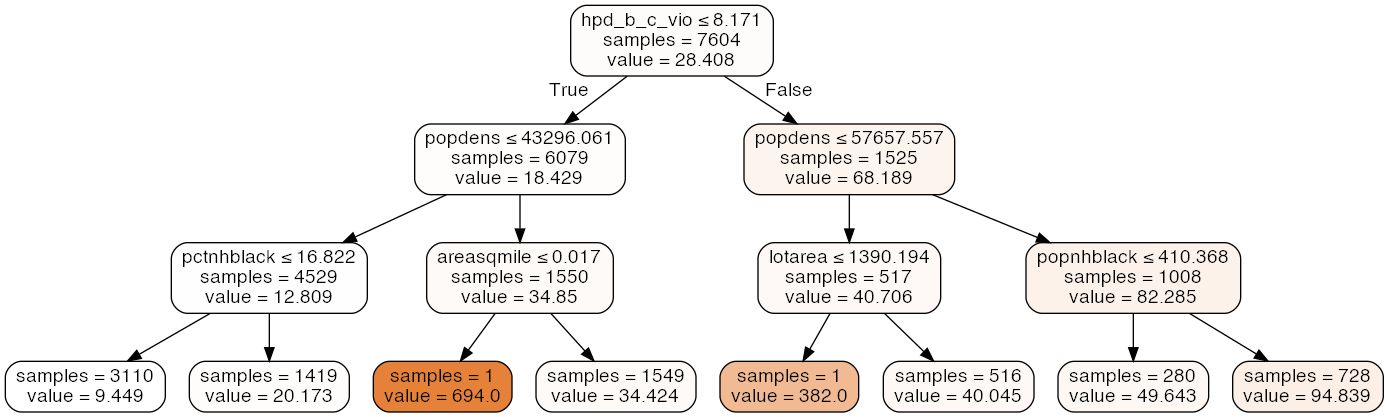

In [113]:
## can we visualize the decision tree?
## for num_fire_ev
from sklearn import tree
from IPython.display import Image  
import pydotplus

dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #bp[1]['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train,y_train.iloc[:, 1])

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt.png'))
Image(graph.create_png())

## Feature Importance

In [83]:
dt = DecisionTreeRegressor(max_depth=rs.best_params_['max_depth'], random_state = 99)
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft1= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft1

,variables,importance
13,tot_hpd_vio,0.585499
24,popdens,0.208921
34,popnhblack,0.092236
25,areasqmile,0.088699
64,pctnhblack,0.024644
48,roc_halfless,0.0
52,roc_2plus,0.0
51,roc_onehalf_2,0.0
50,roc_1_onehalf,0.0
49,roc_half_1,0.0


In [84]:
dt = DecisionTreeRegressor(max_depth=4, random_state = 99)
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order (using max_Depth = 4)
ft2= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft2

,variables,importance
13,tot_hpd_vio,0.504256
24,popdens,0.179931
34,popnhblack,0.079438
25,areasqmile,0.076391
2,numbldgs,0.044458
65,pctnhaian,0.044351
64,pctnhblack,0.039669
58,pct18under,0.019316
61,pct65plus,0.006512
48,roc_halfless,0.005677


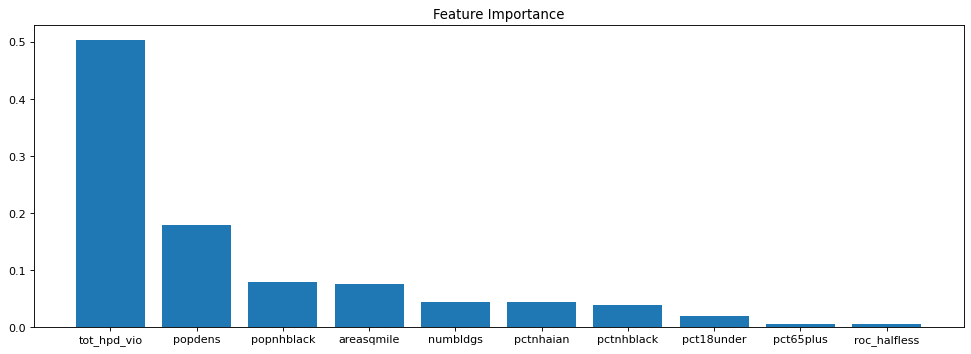

In [86]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(ft2.sort_values(by="importance",ascending=False).iloc[:,0],
        ft2.sort_values(by="importance",ascending=False).iloc[:,1])
plt.title("Feature Importance");

## Random Forests
* Only outcome is number of num_fire_ev

In [87]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_depth = 4, random_state = 99)
rf.fit(X_train, y_train.iloc[:, 1])
y_pred=rf.predict(X_test)
print("R2 with random forest:", rf.score(X_test, y_test.iloc[:, 1]))

R2 with random forest: 0.24968946988348784


In [88]:
param_grid = {'max_depth':range(1,30)}
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99)
gs = GridSearchCV(rf,param_grid=param_grid)
rs = gs.fit(X_train,y_train.iloc[:, 1])
y_pred= rs.predict(X_test)

print(rs.best_params_)
print("R2 with best paramters:", rs.score(X_test, y_test.iloc[:, 1]))

{'max_depth': 7}
R2 with best paramters: 0.24633246107852746


### CMM Method and Other Ensemble Methods
* [From Domingos, 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.40.2710&rep=rep1&type=pdf)
* Not much of an increase in accuracy compared to decision tree model

In [90]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = 7) #rs.best_params_['max_depth'])
rf.fit(X_train,y_train.iloc[:, 1])

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.5*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [91]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([round(pd.DataFrame(y_rand)), y_train.iloc[:, 1]], axis = 0, ignore_index = True)

In [92]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeRegressor()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train_cmm, y_train_cmm)

print(rs.best_params_)
print(rs.score(X_test, y_test.iloc[:, 1]))

{'max_depth': 3}
0.2172983556250645


In [93]:
## prediction
pred = rs.predict(X_test)
pred

array([28.94010417, 20.50045249, 20.50045249, ..., 20.50045249,
       20.50045249, 28.94010417])

In [118]:
dt = DecisionTreeRegressor(max_depth= 3, random_state = 99) #rs.best_params_['max_depth']) # since max depth is optimal for 3, use that
dt.fit(X_train_cmm, y_train_cmm)

DecisionTreeRegressor(max_depth=3, random_state=99)

In [122]:
Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most importnat features in order (using max_depth = 10)
ft3= Feature_importance.sort_values(by="importance",ascending=False)
ft3.loc[ft2['importance']>0]

,variables,importance
24,popdens,0.595419
34,popnhblack,0.196585
15,hpd_b_c_vio,0.166756
55,medianhhincome,0.022785
56,gini,0.018456


In [ ]:
## we can plot this
from sklearn import tree
from IPython.display import Image  
import pydotplus

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no weapon found','weapon found'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_cmm.png'))
Image(graph.create_png())

# (2) Bayes Nets

In [13]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [14]:
## need to discretize outcomes
df_box_disc= df_box.copy()

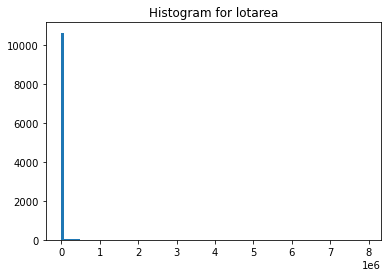

None


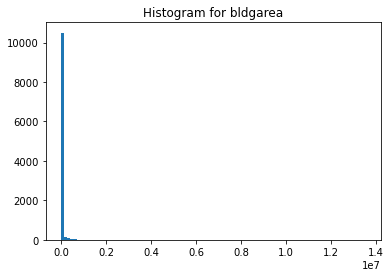

None


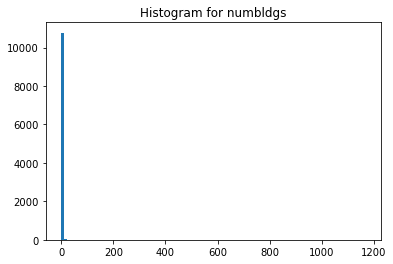

None


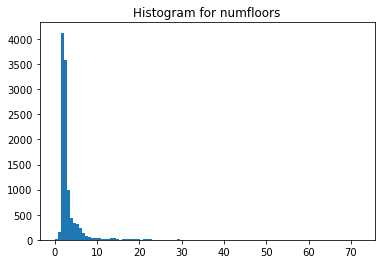

None


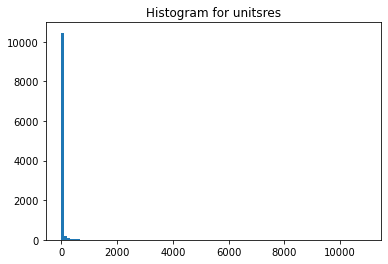

None


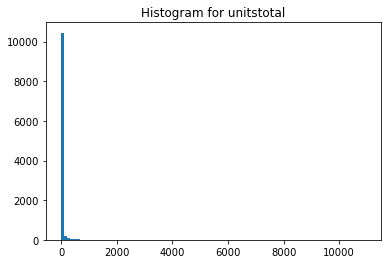

None


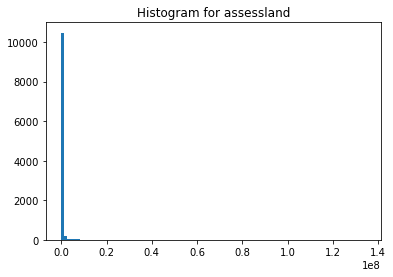

None


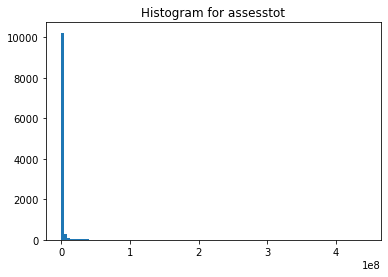

None


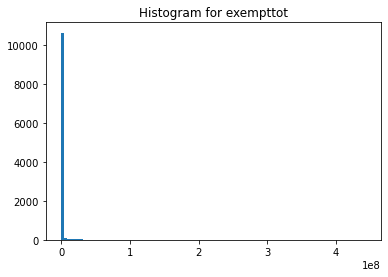

None


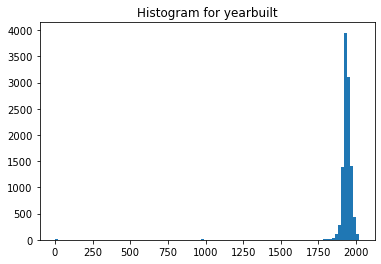

None


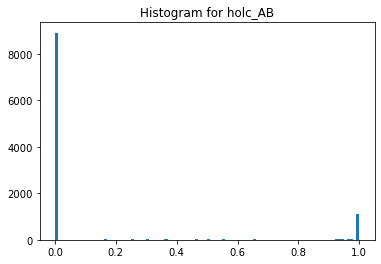

None


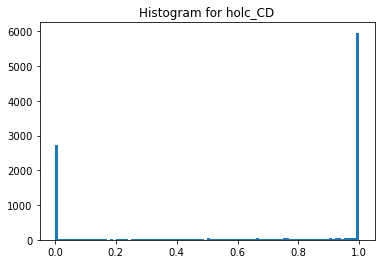

None


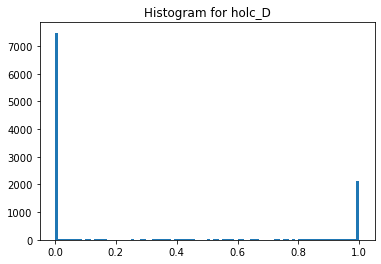

None


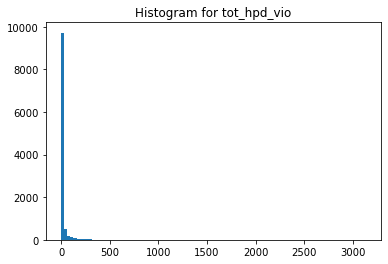

None


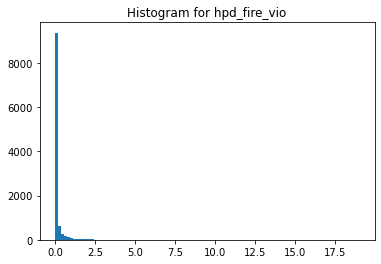

None


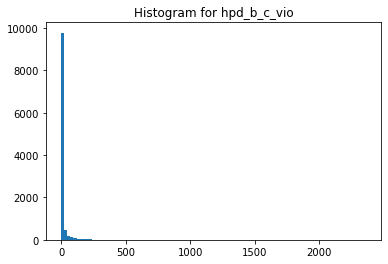

None


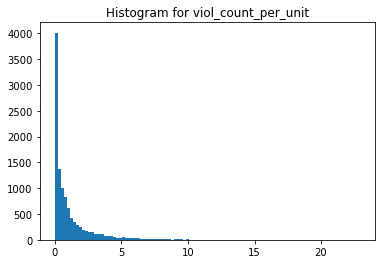

None


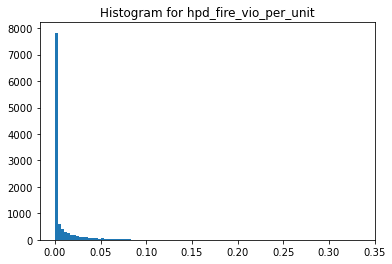

None


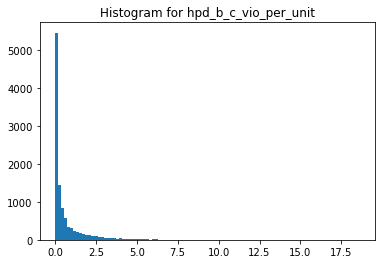

None


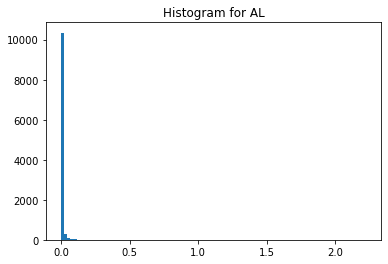

None


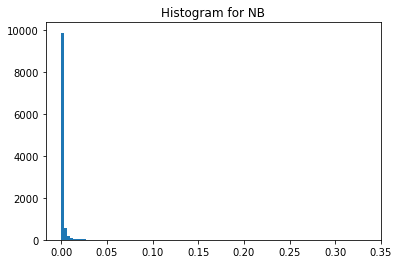

None


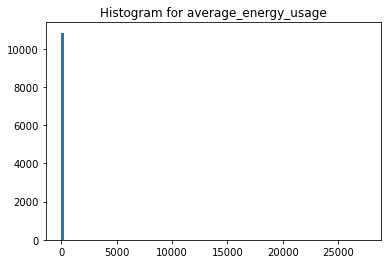

None


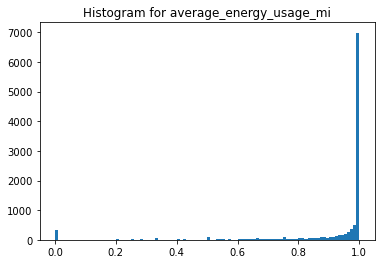

None


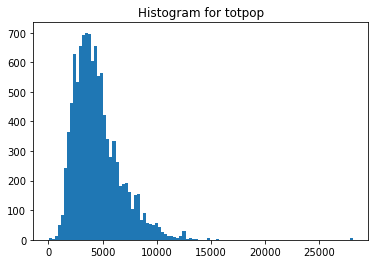

None


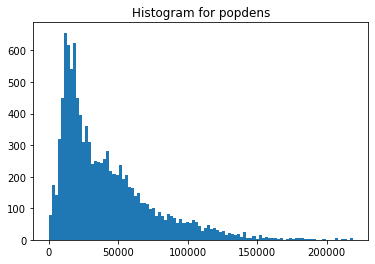

None


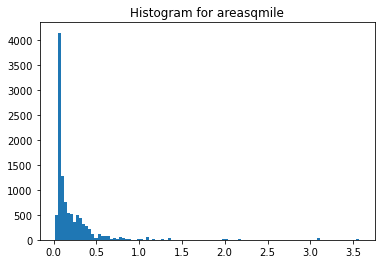

None


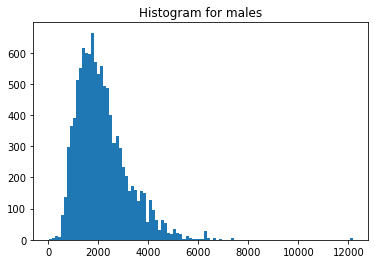

None


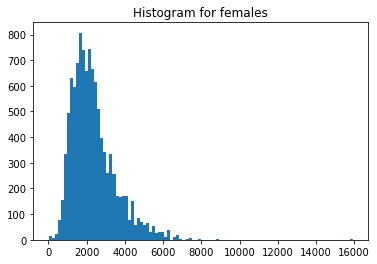

None


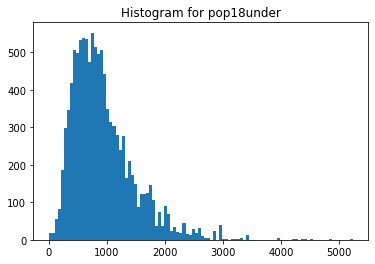

None


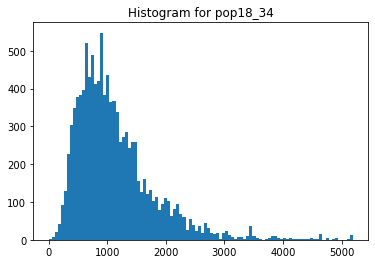

None


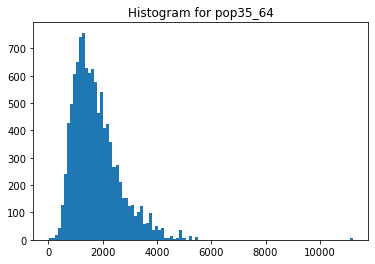

None


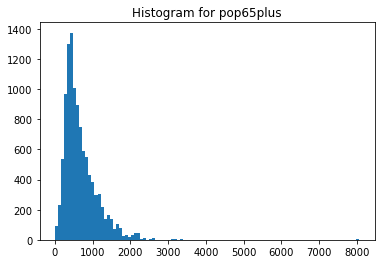

None


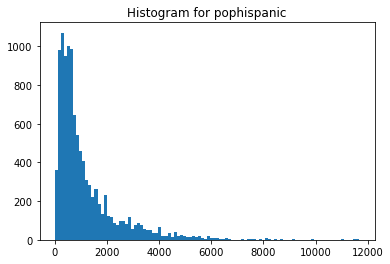

None


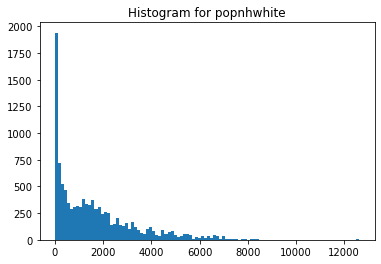

None


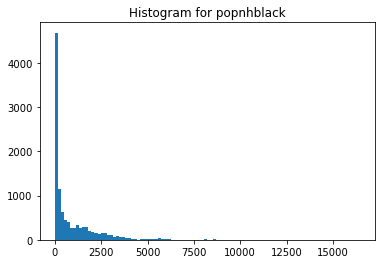

None


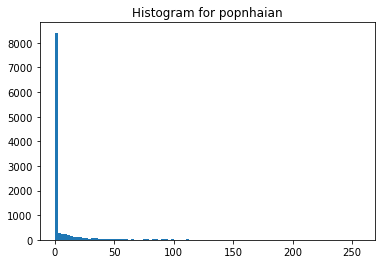

None


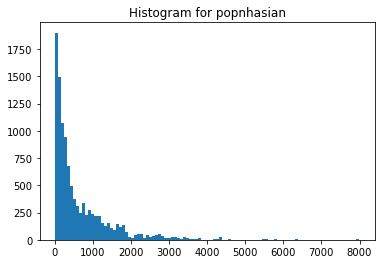

None


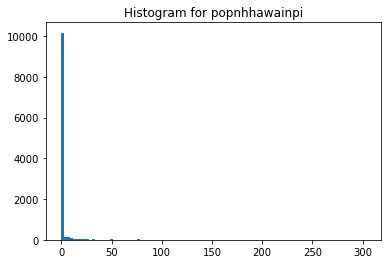

None


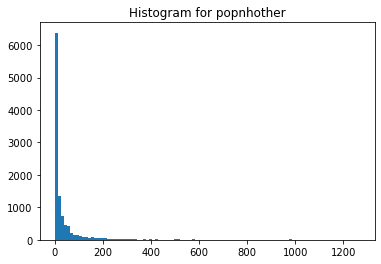

None


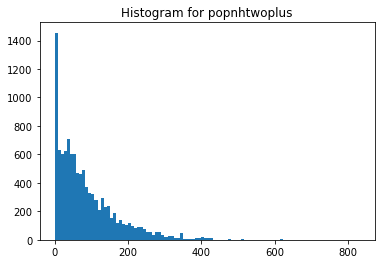

None


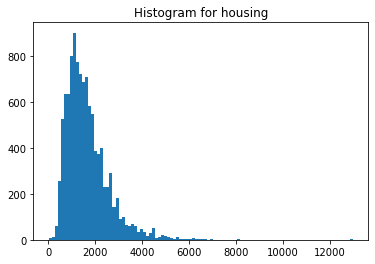

None


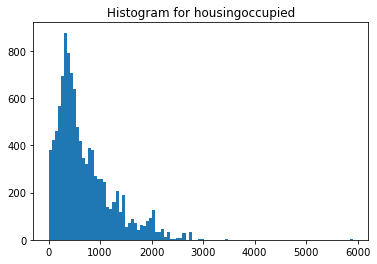

None


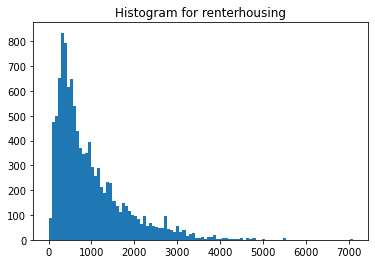

None


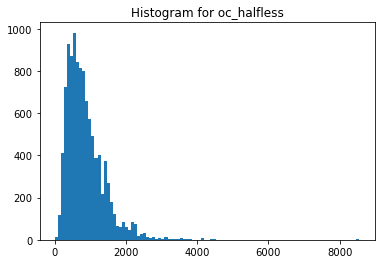

None


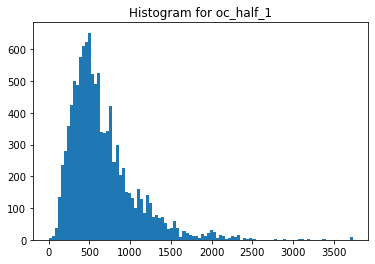

None


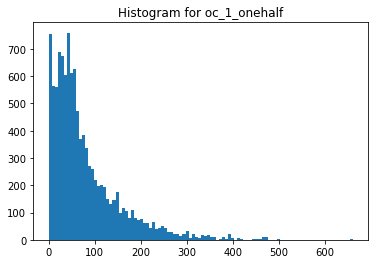

None


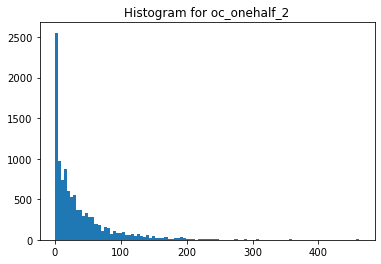

None


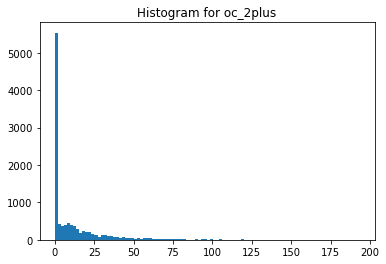

None


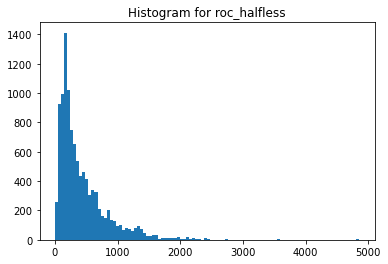

None


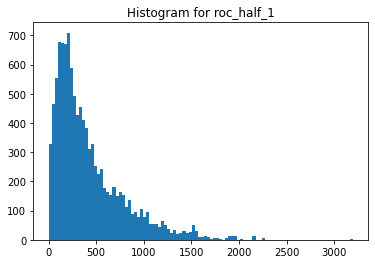

None


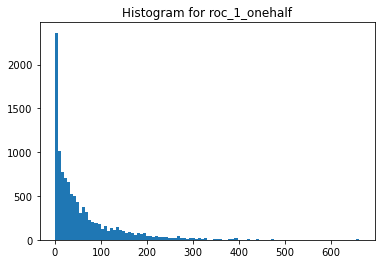

None


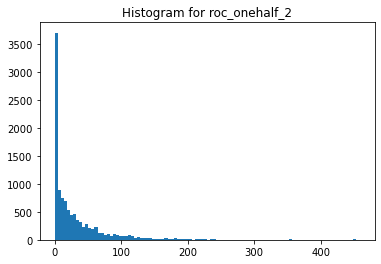

None


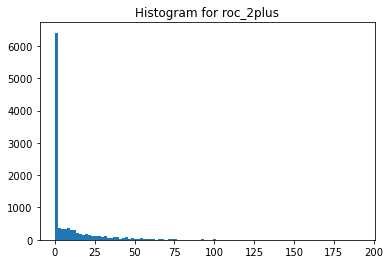

None


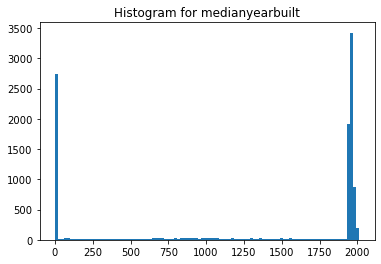

None


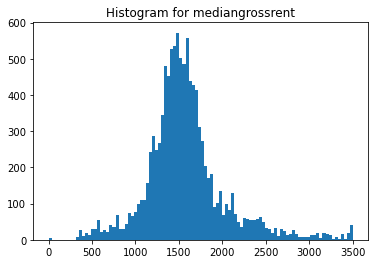

None


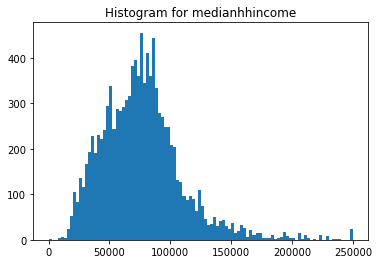

None


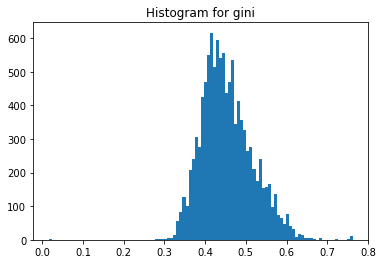

None


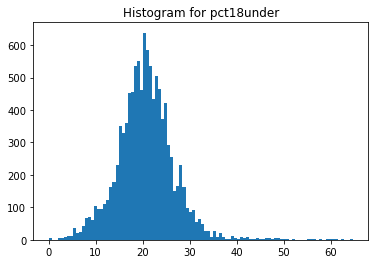

None


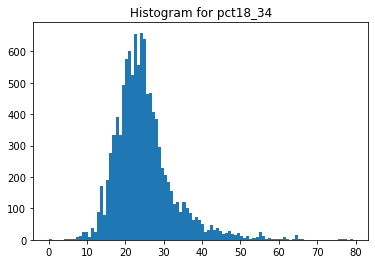

None


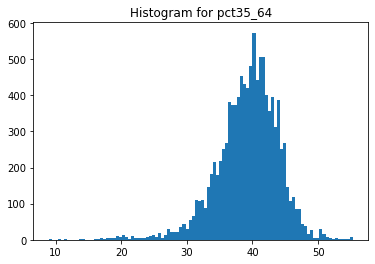

None


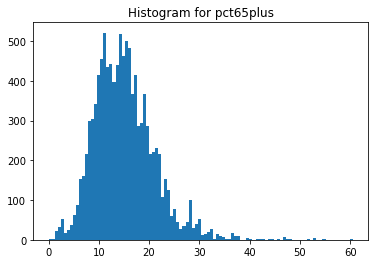

None


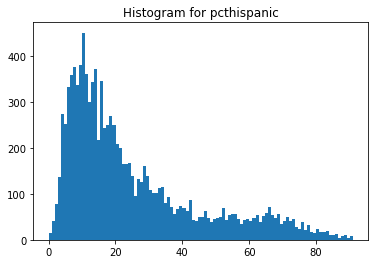

None


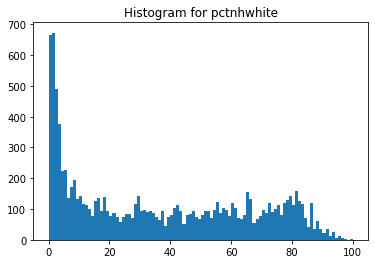

None


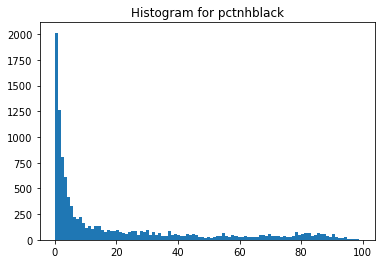

None


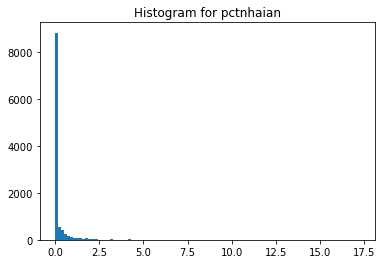

None


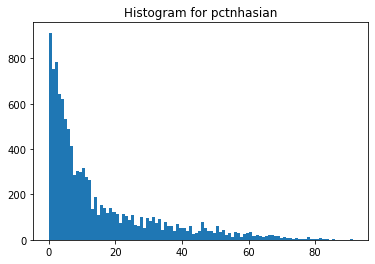

None


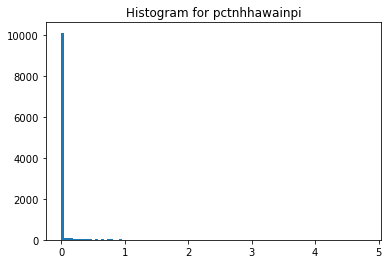

None


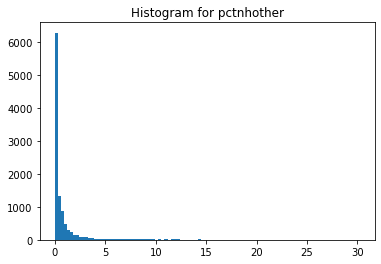

None


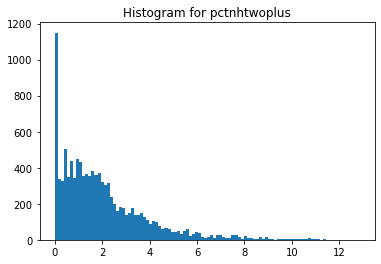

None


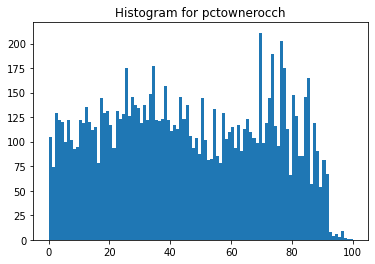

None


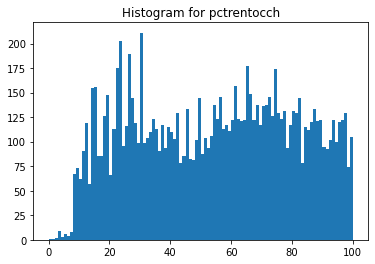

None


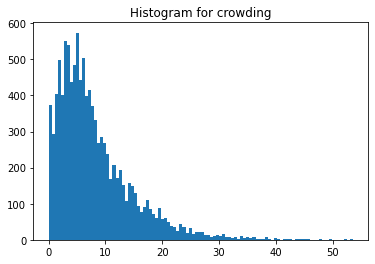

None


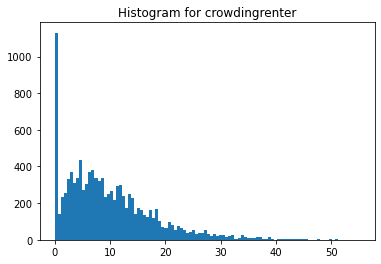

None


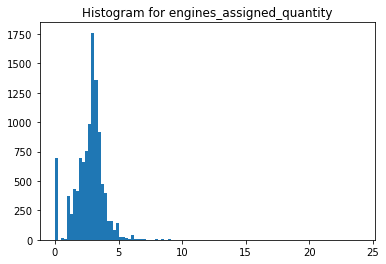

None


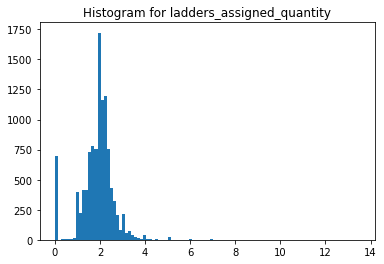

None


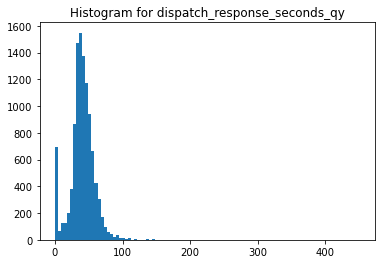

None


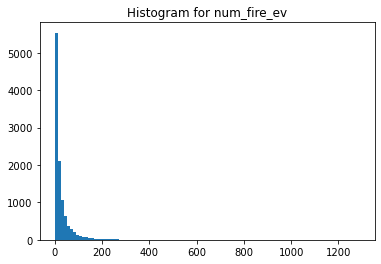

None


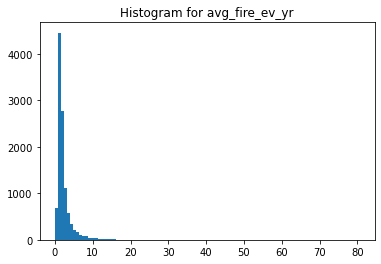

None


In [15]:
# discretize each variable to four equal-frequency bins (quartiles)
for i in df_box_disc.columns[1:]:
    if len(df_box_disc.loc[:, i].unique()) > 5:
        plt.hist(df_box_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_box_disc.loc[:, i] = pd.qcut(df_box_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [16]:
## important vars
#impt_vars= outcomes[0:2] + ft2["variables"].tolist()
impt_vars= outcomes[0:2] + ['hpd_b_c_vio', 'bldgarea', 'unitsres', 'pctnhblack', 'pcthispanic',
                            'hpd_fire_vio', 'holc_D', 'NB', 'AL', 'popdens', 'medianhhincome', 'pct65plus',
                            'pctownerocch', 'pctrentocch', 'crowdingrenter'] #ft.loc[ft['importance']>0, "variables"].tolist()
impt_vars

['dispatch_response_seconds_qy',
 'num_fire_ev',
 'hpd_b_c_vio',
 'bldgarea',
 'unitsres',
 'pctnhblack',
 'pcthispanic',
 'hpd_fire_vio',
 'holc_D',
 'NB',
 'AL',
 'popdens',
 'medianhhincome',
 'pct65plus',
 'pctownerocch',
 'pctrentocch',
 'crowdingrenter']

In [19]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [20]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('num_fire_ev', 'dispatch_response_seconds_qy'), ('hpd_b_c_vio', 'hpd_fire_vio'), ('hpd_b_c_vio', 'num_fire_ev'), ('bldgarea', 'unitsres'), ('bldgarea', 'AL'), ('bldgarea', 'medianhhincome'), ('bldgarea', 'pct65plus'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'pctrentocch'), ('unitsres', 'popdens'), ('pctnhblack', 'hpd_b_c_vio'), ('pctnhblack', 'crowdingrenter'), ('pcthispanic', 'pctnhblack'), ('popdens', 'num_fire_ev'), ('popdens', 'AL'), ('medianhhincome', 'pcthispanic'), ('medianhhincome', 'crowdingrenter'), ('medianhhincome', 'pctnhblack'), ('pct65plus', 'holc_D'), ('pct65plus', 'pcthispanic'), ('pct65plus', 'pctnhblack'), ('pctownerocch', 'popdens'), ('pctownerocch', 'medianhhincome'), ('pctownerocch', 'dispatch_response_seconds_qy'), ('pctownerocch', 'holc_D'), ('pctrentocch', 'pctownerocch'), ('pctrentocch', 'pct65plus'), ('pctrentocch', 'hpd_fire_vio')]


In [21]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['dispatch_response_seconds_qy', 'num_fire_ev', 'hpd_b_c_vio', 'bldgarea', 'unitsres', 'pctnhblack', 'pcthispanic', 'hpd_fire_vio', 'holc_D', 'NB', 'AL', 'popdens', 'medianhhincome', 'pct65plus', 'pctownerocch', 'pctrentocch', 'crowdingrenter']


In [22]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of num_fire_ev:
+----------------+----------------------+-----+---------------------+---------------------+
| hpd_b_c_vio    | hpd_b_c_vio(0)       | ... | hpd_b_c_vio(3)      | hpd_b_c_vio(3)      |
+----------------+----------------------+-----+---------------------+---------------------+
| popdens        | popdens(0)           | ... | popdens(2)          | popdens(3)          |
+----------------+----------------------+-----+---------------------+---------------------+
| num_fire_ev(0) | 0.5998123324396782   | ... | 0.1086515028432169  | 0.04107907656951844 |
+----------------+----------------------+-----+---------------------+---------------------+
| num_fire_ev(1) | 0.3046916890080429   | ... | 0.12381532629298674 | 0.04692886242557192 |
+----------------+----------------------+-----+---------------------+---------------------+
| num_fire_ev(2) | 0.08249329758713136  | ... | 0.34044137557541293 | 0.16058184477175388 |
+----------------+----------------------+-----+-------------

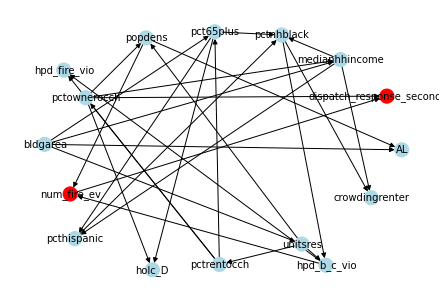

<Figure size 864x720 with 0 Axes>

In [23]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev', 'dispatch_response_seconds_qy'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_.png')

In [24]:
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['num_fire_ev', 'dispatch_response_seconds_qy']]])
print(pred)

  0%|          | 0/2803 [00:00<?, ?it/s]

      num_fire_ev  dispatch_response_seconds_qy
0               3                             1
1               2                             2
2               0                             0
3               0                             0
4               0                             0
...           ...                           ...
3255            3                             1
3256            2                             3
3257            0                             0
3258            2                             3
3259            3                             1

[3260 rows x 2 columns]


In [25]:
for i in impt_vars[0:2]:
    print("\nOS accuracy for: {}".format(i))
    print((pred[i] == test[i].reset_index(drop = True)).mean())


OS accuracy for: dispatch_response_seconds_qy
0.34662576687116564

OS accuracy for: num_fire_ev
0.4708588957055215


In [26]:
# prediction just for time to the fire
pred = model.predict(test.loc[:, [n for n in model.nodes() if n not in ['dispatch_response_seconds_qy']]], stochastic = True)
print(pred)

  0%|          | 0/2996 [00:00<?, ?it/s]

       dispatch_response_seconds_qy
2261                              2
1859                              2
5182                              3
5343                              3
6263                              2
...                             ...
3325                              1
4919                              0
6346                              0
2351                              3
10018                             3

[3260 rows x 1 columns]


In [28]:
print("\nOS accuracy time to the fire, includes num_fire_ev as predictor")
print((pred['dispatch_response_seconds_qy'].reset_index(drop = True) == test['dispatch_response_seconds_qy'].reset_index(drop = True)).mean())


OS accuracy time to the fire, includes num_fire_ev as predictor
0.32331288343558284


### PC Method for Causal Model calculations

In [29]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

In [31]:
# create test train split for testing DAG
train, test = train_test_split(df_box_disc.loc[:, ['num_fire_ev', 'popdens', 'hpd_b_c_vio', 'bldgarea', 'unitsres']], test_size=0.3, random_state=999)

In [32]:
pc_est = PC(train)

# Step 1: construct undirected skeleton
skel, separating_sets = pc_est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('num_fire_ev', 'popdens'), ('num_fire_ev', 'hpd_b_c_vio'), ('num_fire_ev', 'bldgarea'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'bldgarea'), ('popdens', 'unitsres'), ('hpd_b_c_vio', 'bldgarea'), ('hpd_b_c_vio', 'unitsres'), ('bldgarea', 'unitsres')]


In [34]:
# Step 2: partially directed acyclic graph 
pdag = pc_est.skeleton_to_pdag(skel, separating_sets)
print("PDAG edges:       ", pdag.edges())

PDAG edges:        [('hpd_b_c_vio', 'bldgarea'), ('hpd_b_c_vio', 'unitsres'), ('hpd_b_c_vio', 'num_fire_ev'), ('hpd_b_c_vio', 'popdens'), ('bldgarea', 'hpd_b_c_vio'), ('bldgarea', 'popdens'), ('bldgarea', 'unitsres'), ('bldgarea', 'num_fire_ev'), ('unitsres', 'popdens'), ('unitsres', 'hpd_b_c_vio'), ('unitsres', 'bldgarea'), ('popdens', 'num_fire_ev'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'bldgarea'), ('popdens', 'unitsres'), ('num_fire_ev', 'popdens'), ('num_fire_ev', 'bldgarea'), ('num_fire_ev', 'hpd_b_c_vio')]


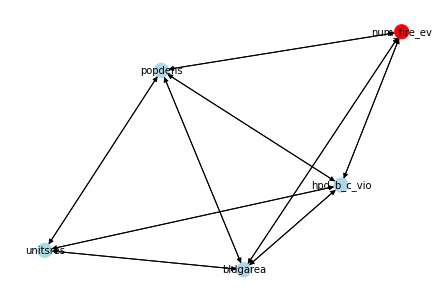

<Figure size 864x720 with 0 Axes>

In [36]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in pdag.nodes()]
# use networkx to draw DAG
nx.draw(pdag, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('pdag_box.png')

In [37]:
model = pc_est.estimate()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

DAG edges:         [('hpd_b_c_vio', 'unitsres'), ('bldgarea', 'unitsres'), ('bldgarea', 'hpd_b_c_vio'), ('popdens', 'unitsres'), ('popdens', 'hpd_b_c_vio'), ('popdens', 'bldgarea'), ('num_fire_ev', 'hpd_b_c_vio'), ('num_fire_ev', 'bldgarea'), ('num_fire_ev', 'popdens')]


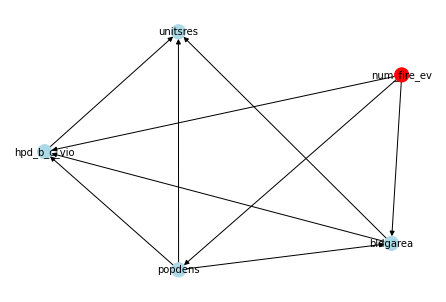

<Figure size 864x720 with 0 Axes>

In [39]:
fig = plt.gcf()

values = ['red' if n in ['num_fire_ev'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('model_pdag_est_box.png')